In [1]:
%load_ext Cython
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt  
import scipy.interpolate
from scipy.ndimage.interpolation import rotate

In [41]:
def low_pass_filter(img):
    n0, n1 = img.shape

    x, y = np.mgrid[0:n0, 0:n1]
    x -= n0//2
    y -= n1//2
    r = np.sqrt(x*x + y*y)

    fil = np.fft.ifftshift(np.where(r < min(n0, n1)/3, 1, 0))

    filtered_img = np.fft.ifft2( np.fft.fft2(img) * fil ).real
    return filtered_img

def slices_gen(img, thetas):
    l_max = np.max(img.shape)
    slices = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        mid = rotated_img[rotated_img.shape[0]//2, :]
        pad_width = [int(np.floor(l_max - len(mid))/2.), int(np.ceil((l_max - len(mid))/2.))]
        mid = np.pad(mid, pad_width, mode = "constant", constant_values = 0)
        slices[i] = mid
    return slices

def radon(img, thetas):
    l_max = np.max(img.shape)
    sinogram = np.zeros([len(thetas), l_max], dtype = np.float64)
    for i, theta in enumerate(thetas):
        rotated_img = rotate(img, -theta, reshape = False, prefilter = False)
        proj = np.sum(rotated_img, axis = 0)
        pad_width = [int(np.floor(l_max - len(proj))/2.), int(np.ceil((l_max - len(proj))/2.))]
        proj = np.pad(proj, pad_width, mode = "constant", constant_values = 0)
        sinogram[i] = proj
    return sinogram.T

def iradon(sinogram, thetas):
    n0, n1 = sinogram.shape
    assert(n1 == len(thetas))
    thetas = thetas / 180 * np.pi
    fil = np.abs(np.fft.fftfreq(n0)).reshape((-1, 1))
    filtered_sino = np.fft.ifft(np.fft.fft(sinogram, axis = 0) * fil, axis = 0).real

    x, y = np.mgrid[0:n0,0:n0]
    x -= n0//2
    y -= n0//2
    t = np.arange(n0) - n0//2

    recon = np.zeros([n0,n0], dtype = np.float64)
    for i,theta in enumerate(thetas):
        tt = -x*np.sin(theta) + y*np.cos(theta)
        back_proj = np.interp(tt, t, filtered_sino[:,i])
        recon += back_proj
    return recon

def recon_f(sinogram, thetas):
    n0, n1 = sinogram.shape
    c = n0//2
    
    freq = np.fft.fftfreq(n0)
    f0, f1 = np.meshgrid(freq, freq, indexing = "ij")
    phasor = 2*np.pi*c*np.fft.fftshift(freq).reshape((-1,1))
    phasor2 = -2*np.pi*(c*f0 + c*f1)

    ft_sino = np.fft.fftshift( np.fft.fft(sinogram, axis = 0), axes = 0 )
    ft_sino *= np.exp(1j*phasor)
    slices_real = np.real(ft_sino).T
    slices_imag = np.imag(ft_sino).T

    model_real = insert(slices_real, thetas)
    model_imag = insert(slices_imag, thetas)
    model = model_real + 1j*model_imag
    model *= np.exp(1j*phasor2)

    recon = np.real(np.fft.ifft2(np.fft.ifftshift(model)))

    return model, recon

In [42]:
%%cython
import numpy as np 
cimport numpy as np 
from libc.math cimport sin, cos

def insert(np.ndarray[np.float64_t, ndim = 2] slices, np.ndarray[np.float64_t, ndim = 1] thetas):

    thetas = thetas / 180 * np.pi
    cdef np.ndarray[np.float64_t, ndim = 1] slc
    cdef int s0, s1, sc, c0, c1, x, y
    cdef double xx, yy, fx, fy, ifx, ify, w, th
    cdef Py_ssize_t i, t


    s0 = slices.shape[0]
    s1 = slices.shape[1]
    assert(s0 == len(thetas))
    n0 = s1
    n1 = s1

    sc = s1 // 2
    c0 = n0 // 2
    c1 = n1 // 2

    cdef np.ndarray[np.float64_t, ndim = 2] model = np.zeros((n0, n1), dtype = np.float64)
    cdef np.ndarray[np.float64_t, ndim = 2] weight = np.zeros((n0, n1), dtype = np.float64)

    for i, th in enumerate(thetas):
        slc = slices[i]
        for t, v in enumerate(slc):
            x = 0
            y = t - sc

            xx = cos(th)*x - sin(th) * y
            yy = sin(th)*x + cos(th) * y

            xx += c0
            yy += c1

            if xx <= 0 or xx >= n0 - 1: continue
            if yy <= 0 or yy >= n1 - 1: continue

            xxx = <int>xx
            yyy = <int>yy

            fx = xx - xxx
            fy = yy - yyy
            ifx = 1. - fx
            ify = 1. - fy

            w = ifx * ify
            model[xxx, yyy] += w*v 
            weight[xxx, yyy] += w

            w = ifx * fy
            model[xxx, yyy + 1]  += w*v
            weight[xxx, yyy + 1] += w

            w = fx * fy
            model[xxx + 1, yyy + 1] += w*v
            weight[xxx + 1, yyy + 1] += w

            w = fx * ify
            model[xxx + 1, yyy] += w*v
            weight[xxx + 1, yyy] += w

    weight =  np.where(weight == 0., 1., weight)
    return model / weight


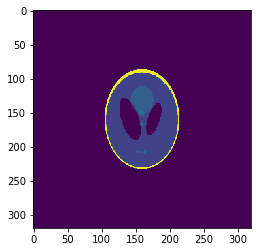

In [32]:
### Construct phantom
origin = np.load("phantom_small.npy")
N0, N1 = origin.shape
origin = np.pad(origin, pad_width = N0//2, mode = "constant", constant_values = 0)
# origin = low_pass_filter(origin)
thetas = np.arange(180)
thetas = np.asarray(thetas, dtype = np.float64)
ft_origin = np.fft.fft2(origin)
ft_origin = np.fft.fftshift(ft_origin)
plt.imshow(origin)

In [25]:
sinogram = radon(origin, thetas)

In [26]:
recon_FBP = iradon(sinogram, thetas)

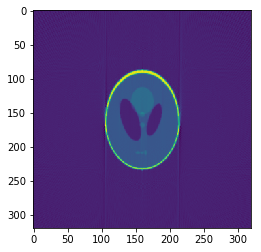

In [27]:
plt.imshow(recon_FBP)

In [43]:
model, recon_FTM = recon_f(sinogram, thetas)

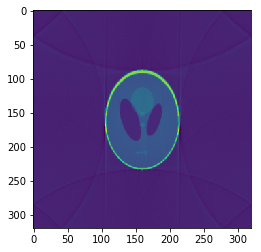

In [44]:
plt.imshow(recon_FTM)

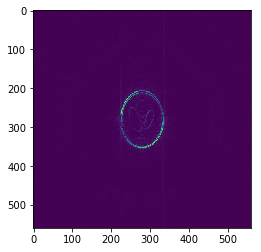

In [13]:
plt.imshow(np.abs(origin - recon_FTM))

In [87]:
slices = slices_gen(phantom, thetas)

In [88]:
recon_real = insert(slices, thetas)

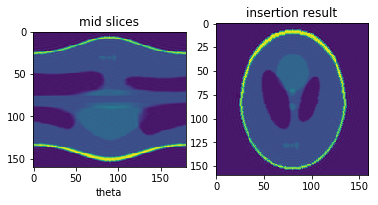

In [89]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.imshow(slices.T)
ax1.set_title("mid slices")
ax1.set_xlabel("theta")
ax2.imshow(recon_real)
ax2.set_title("insertion result")

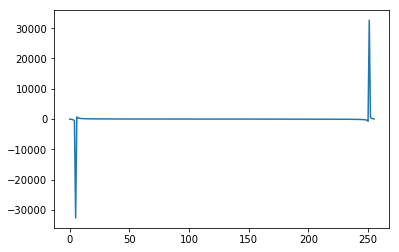

In [20]:
x=np.linspace(0,np.pi*10,256)
y=np.sin(x)
yy = np.fft.fft(y)
plt.plot(np.imag(yy)*256)

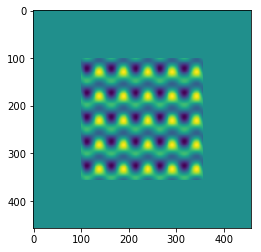

In [89]:
X, Y = np.mgrid[-5*np.pi:5*np.pi:256*1j, -5*np.pi:5*np.pi:256*1j]
y1 = np.sin(X)
y2 = np.sin(X+Y)
y3 = np.sin(-X+Y)
y4 = np.sin(Y)
im = y1+y2+y3+y4
im = np.pad(im, pad_width = [[100,101],[100,101]], mode="constant", constant_values = 0)
plt.imshow(im)
thetas = np.arange(0,180, dtype = np.float64)

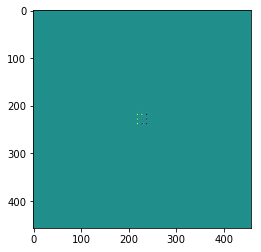

In [90]:
ft_im = np.fft.fft2(im)
ft_im = np.fft.fftshift(ft_im)



plt.imshow(ft_im.imag)

In [91]:
slcs_real = slices_gen(ft_im.real, thetas)
slcs_imag = slices_gen(ft_im.imag, thetas)
recon_real = insert(slcs_real, thetas)
recon_imag = insert(slcs_imag, thetas)
recon = recon_real + 1j*recon_imag

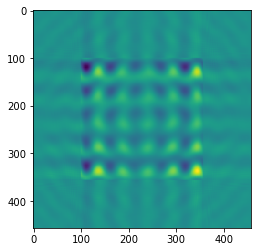

In [92]:
plt.imshow(np.fft.ifft2(np.fft.ifftshift(recon)).real)

[-2, 256, -2, 256]

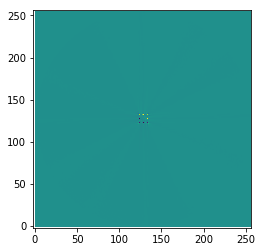

In [14]:
thetas = np.asarray(np.arange(-90,90),dtype=np.float64)
sino = radon(im, 90-thetas)
model, recon = recon_f(sino, thetas)
plt.imshow(model.imag)
plt.axis([-2,256,-2,256])
# print(np.max(model.imag))

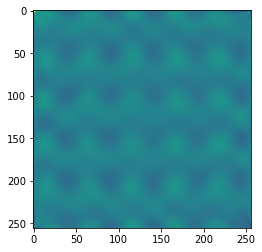

In [15]:
plt.imshow(recon)

In [18]:
err = model - ft_origin

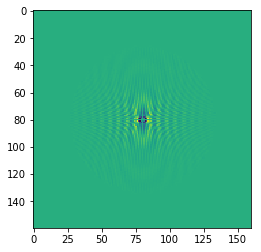

In [25]:
plt.imshow(err.real)

In [26]:
err2 = ft_bp - ft_origin
print(np.max(np.abs(err2.real)))

99604.171382


99604.171382


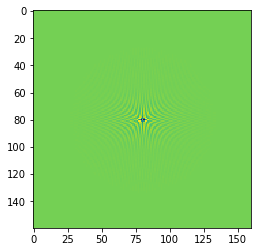

In [27]:
plt.imshow(err2.real)
print(np.max(np.abs(err2.real)))

In [29]:
rr = np.fft.ifft2(np.fft.ifftshift(ft_bp)).real

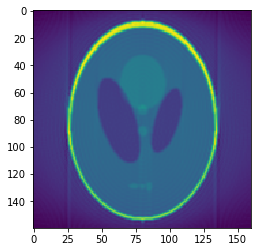

In [30]:
plt.imshow(rr)

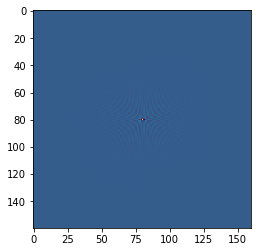

In [32]:
plt.imshow(ft_origin.real)

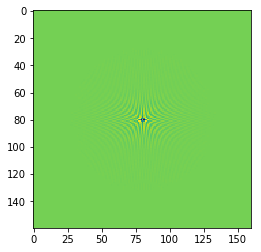

In [33]:
plt.imshow(ft_bp.real)

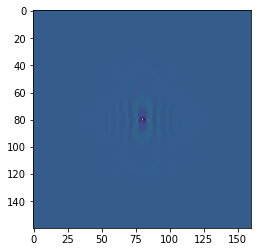

In [34]:
plt.imshow(model.real)

In [96]:
fx,fy=np.meshgrid(np.fft.fftfreq(5), np.fft.fftfreq(5))

In [100]:
np.fft.fftshift(fx)

array([[-0.4, -0.2,  0. ,  0.2,  0.4],
       [-0.4, -0.2,  0. ,  0.2,  0.4],
       [-0.4, -0.2,  0. ,  0.2,  0.4],
       [-0.4, -0.2,  0. ,  0.2,  0.4],
       [-0.4, -0.2,  0. ,  0.2,  0.4]])

In [101]:
fy

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.4,  0.4,  0.4,  0.4,  0.4],
       [-0.4, -0.4, -0.4, -0.4, -0.4],
       [-0.2, -0.2, -0.2, -0.2, -0.2]])